# Hierarchical Modeling
What models fit the data?

# Setup

In [121]:
import pandas as pd
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

#### Parameters

In [122]:
config = {
    "bins": 16,
    "min_bin_percentile": 10,
    "eval_sample_size": 1000,
}

#### Load data

In [123]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

,density,edginess,references,citations_per_year,is_center,identifier,year,librarian,vectorizer,center,fields_of_study_0
0,1545.550332,0.814415,42,2.250000,False,2e5f3e6c87d1676cdeffc3a2bfbc30b6cd06ed6f,2004,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
1,1846.261870,0.452021,88,4.625000,False,d7b6cd39dd111afa55a3aa418b7b5459db12988d,2012,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
2,1703.520959,0.490212,30,0.882353,False,2d62ec65f95435c72ef750b3cff331382c5dca92,2003,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
3,1901.386693,0.715160,95,8.166667,False,8cebc6e3dcfb543bad48d89112e281a6e11c33c2,2014,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
4,535.472125,0.885892,94,2.090909,False,59730a4bae4dc53f59341b63fd1e63451c589e9f,2009,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
...,...,...,...,...,...,...,...,...,...,...,...
537685,48.730838,0.658585,41,3.500000,False,806f77ba7bdf8a3b80cb859fb5f33f57c1d85d24,2018,S2,SciBERT,Andre2018,Mathematics
537686,25.107589,0.721374,38,3.200000,False,f40707d1165c22e185c25e6837977177ee380f2c,2015,S2,SciBERT,Andre2018,Mathematics
537687,41.647954,0.646499,11,1.529412,False,10636ee16779a7521001651164acb5c192d4ad7b,2003,S2,SciBERT,Andre2018,Mathematics
537688,35.738649,0.708053,15,2.384615,False,a229f829e0a5362d00e63781f687f40ede991635,2007,S2,SciBERT,Andre2018,Mathematics


In [124]:
# Basic nan handling across all obs
df_all["log_cpy"] = np.log10(df_all["citations_per_year"])
df_all['log_cpy'] = df_all['log_cpy'].replace(-np.inf, np.nan)

/Users/zhafen/miniconda3/envs/cmdstan/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [125]:
field_names = sorted(df_all["fields_of_study_0"].unique())
field_names

['Economics',
 'Education',
 'Geology',
 'Linguistics',
 'Materials Science',
 'Mathematics',
 'Medicine',
 'Philosophy',
 'Physics']

In [126]:
vectorizer_names = sorted(df_all["vectorizer"].unique())
vectorizer_names

['BOW', 'GPT2', 'SBERT', 'SciBERT', 'Word2Vec']

# Plot

### Brief aside on logscale plotting

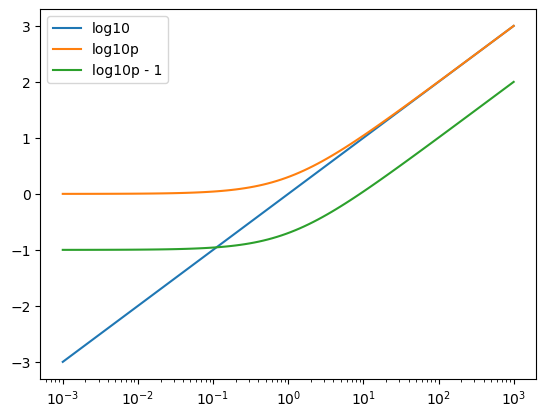

In [127]:
fig = plt.figure()
ax = plt.gca()

x = np.logspace(-3, 3, 100)
log10 = np.log10(x)
log10p = np.log10(1 + x)
log10p2 = np.log10(1 + x) - 1

ax.plot(
    x,
    log10,
    label="log10",
)
ax.plot(
    x,
    log10p,
    label="log10p",
)
ax.plot(
    x,
    log10p2,
    label="log10p - 1",
)

ax.legend()

ax.set_xscale("log")

### Overview Normalized 2D Histogram

In [128]:
def get_bins(x, n_bins=config["bins"]):
    # Get density bins
    bins = np.linspace(
        np.nanpercentile(x, config["min_bin_percentile"]),
        np.nanpercentile(x, 100 - config["min_bin_percentile"]),
        n_bins + 1,
    )
    return bins


density_bins = df_all.groupby("vectorizer")["density"].apply(get_bins).to_dict()
cpy_bins = get_bins(
    df_all["log_cpy"], n_bins=17
)  # The n_bins=17 is to ensure we don't accidentally flip axes

In [129]:
def custom_histplot(data, x, y, normed=True, *args, **kwargs):

    # Get the appropriate facets
    vectorizer = data["vectorizer"].unique()[0]
    field = data["fields_of_study_0"].unique()[0]

    density_bins = get_bins(data[x])

    if normed:
        hist2d, _, _ = np.histogram2d(data[x], data[y], bins=(density_bins, cpy_bins))
        density_hist, _ = np.histogram(data[x], bins=density_bins)
        hist2d_normed = hist2d / density_hist.reshape(1, -1).T

        # Plot the data
        plt.pcolormesh(
            density_bins,
            cpy_bins,
            hist2d_normed.T,
            shading='auto',
            cmap="viridis",
        )
    else:
        sns.histplot(data, x=x, y=y, bins=(density_bins, cpy_bins), *args, **kwargs)

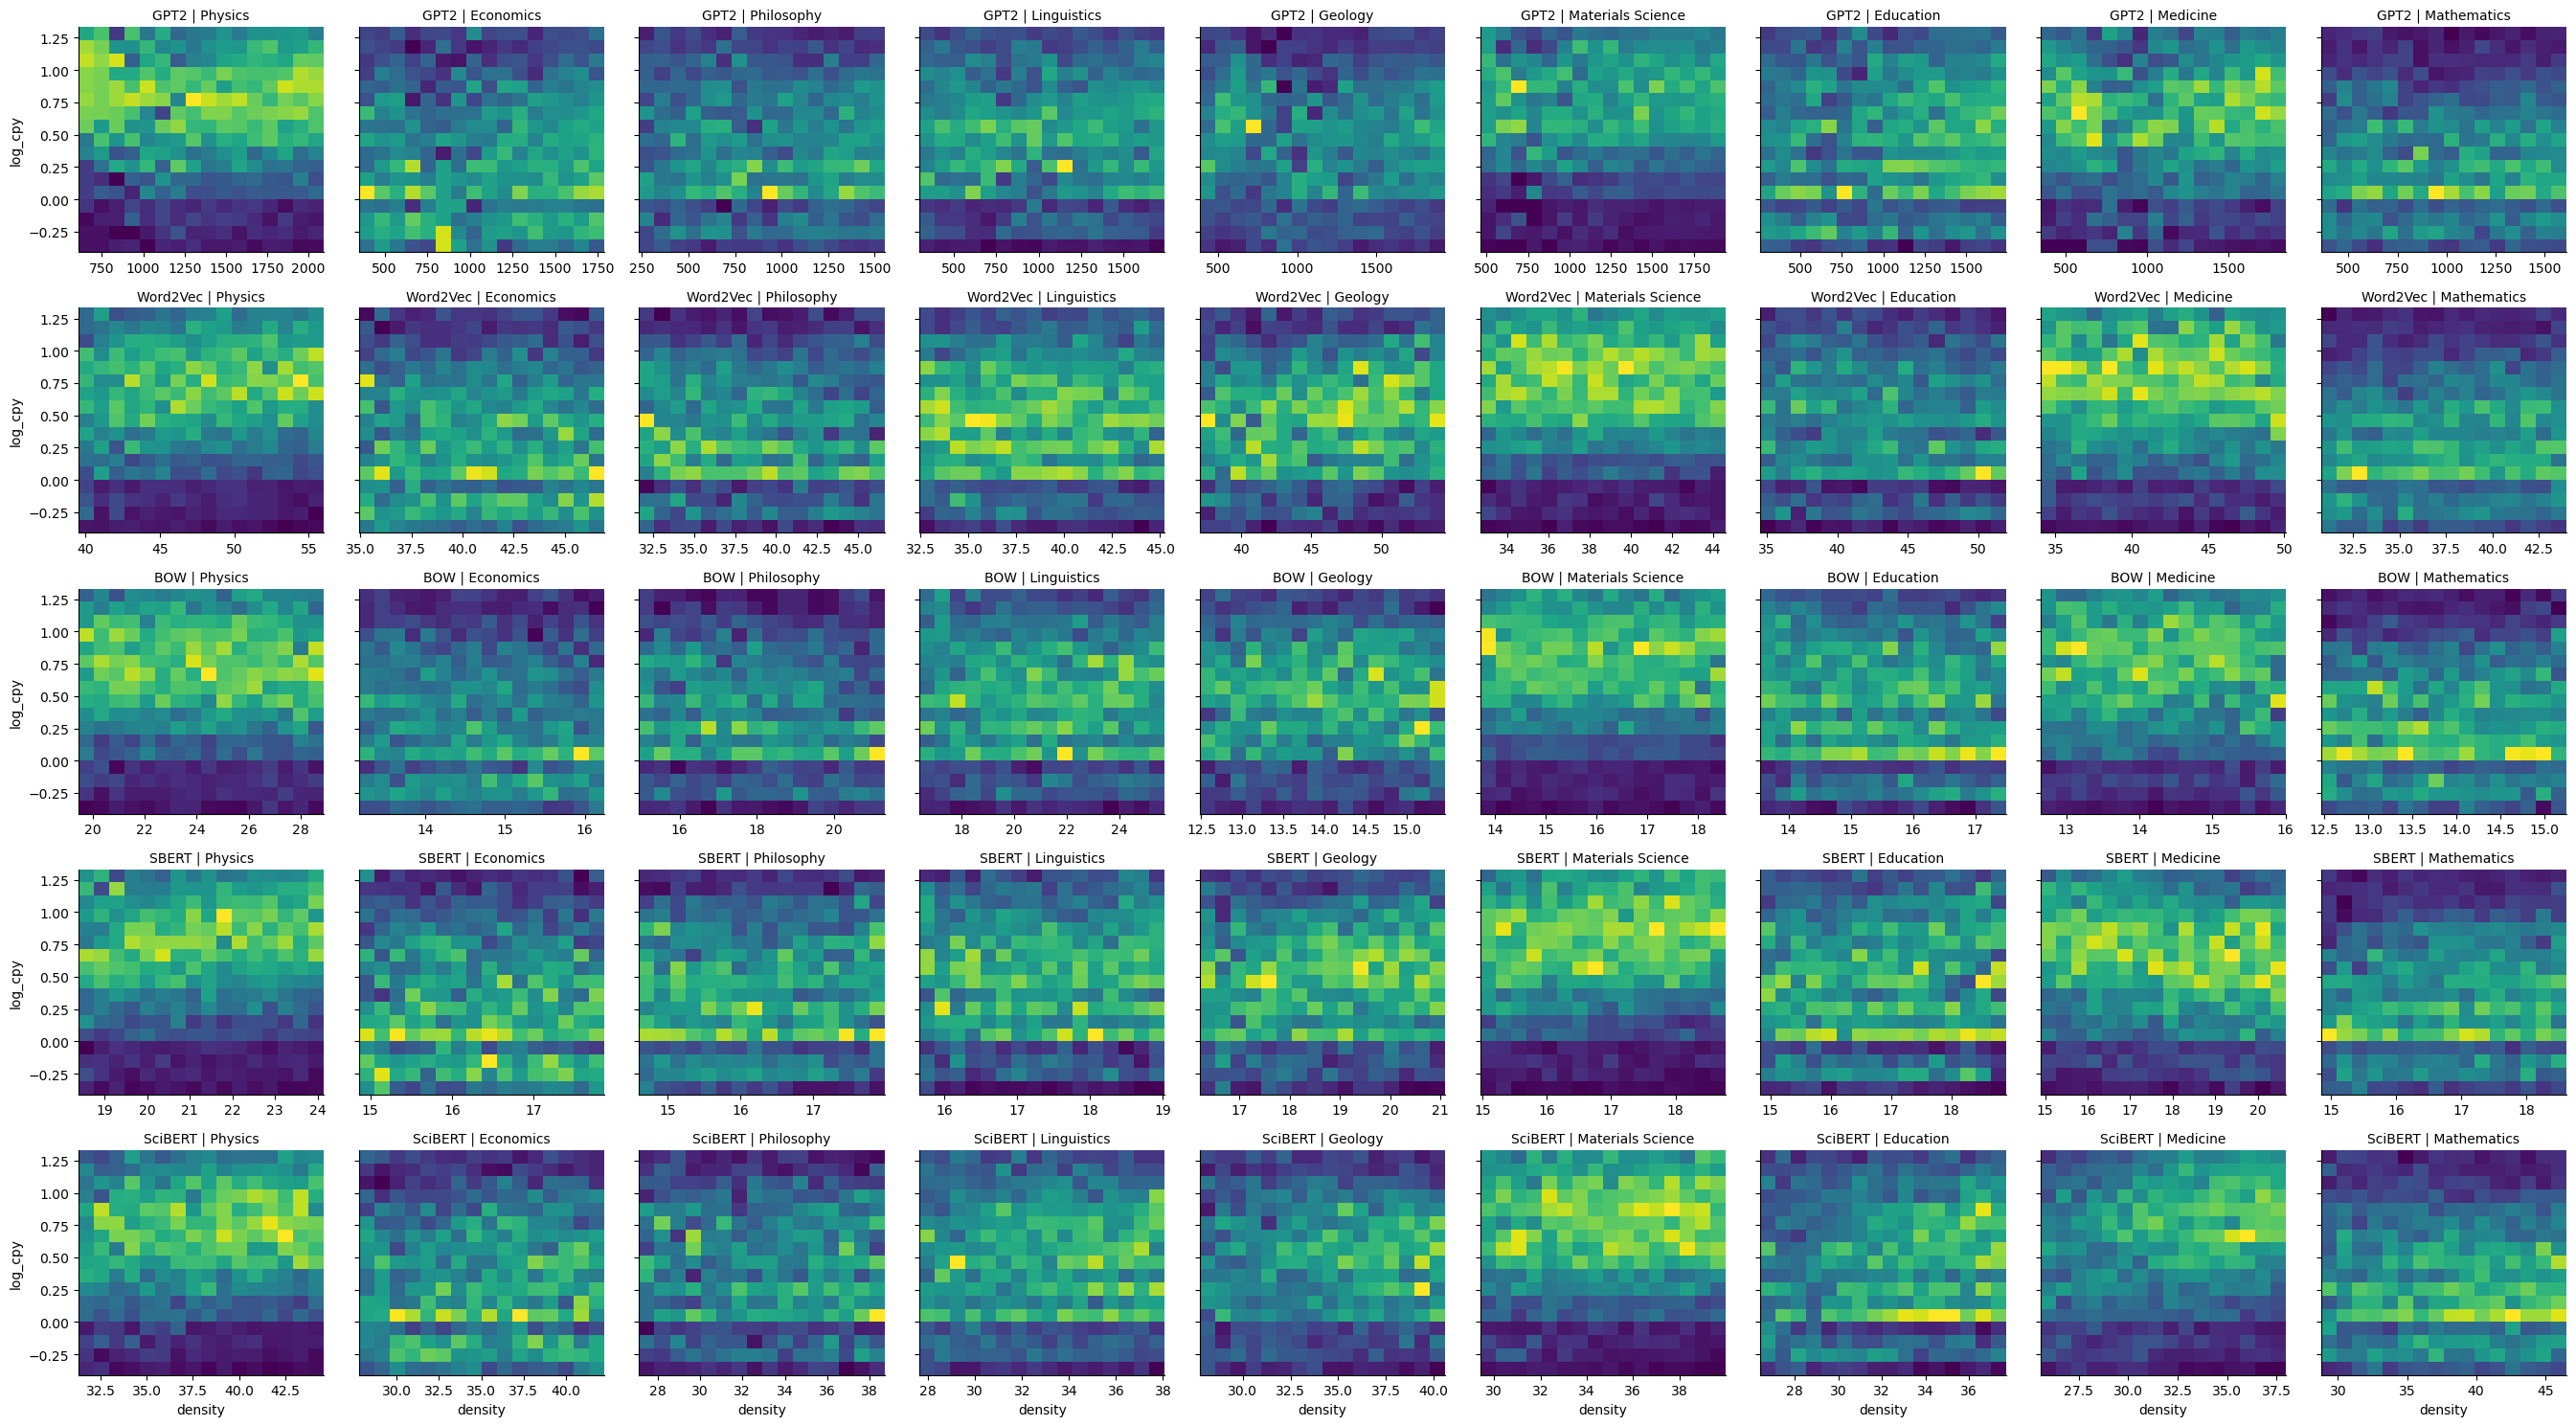

In [130]:
fg = sns.FacetGrid(data=df_all, row="vectorizer", col="fields_of_study_0", sharex=False)
fg.map_dataframe(custom_histplot, x="density", y="log_cpy", normed=True)
fg.set_titles("{row_name} | {col_name}")

### Focused Normalized Histogram

In [131]:
df = df_all.query("vectorizer in ['SciBERT', 'Word2Vec']")

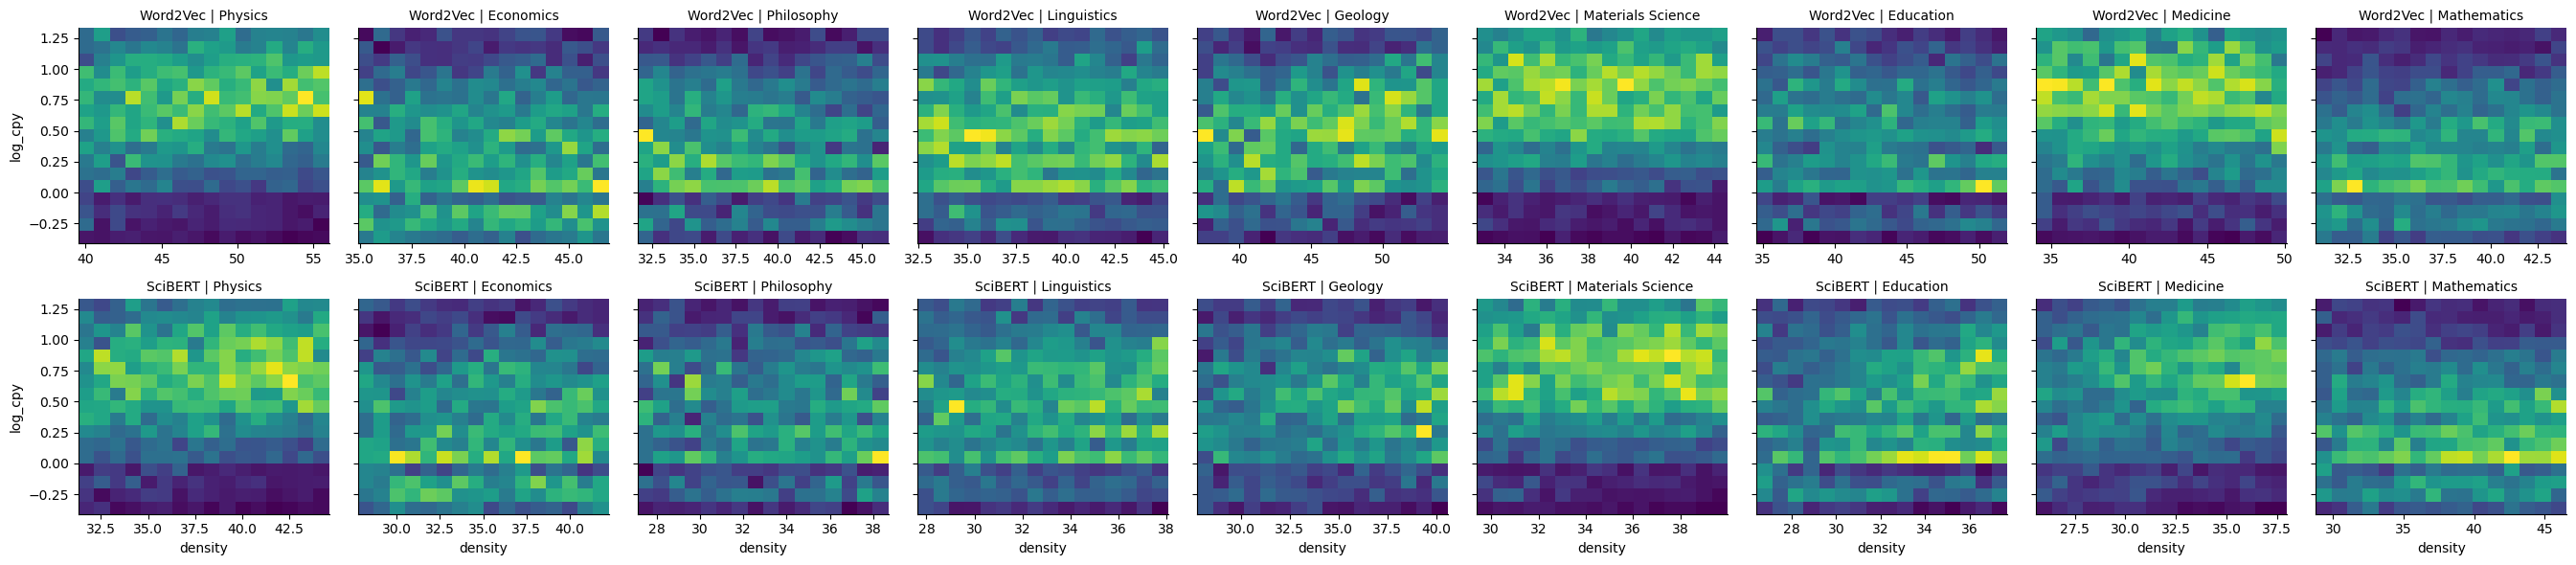

In [132]:
fg = sns.FacetGrid(data=df, row="vectorizer", col="fields_of_study_0", sharex=False)
fg.map_dataframe(custom_histplot, x="density", y="log_cpy", normed=True)
fg.set_titles("{row_name} | {col_name}")

# Statistical Modeling

Note to future self: cmdstanpy and cmdstan advertise conda as *the* way to install.
Don't listen to them.
I couldn't get it to compile when I used conda for anything cmdstanpy related.
I downloaded the repo and compiled manually, and used pip for cmdstanpy.

In [133]:
import cmdstanpy

## Train-Test Split

In [169]:
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [135]:
# Pivot to wide format so we can use the same train_test division
df_eval = df_all.pivot_table(index="identifier", columns="vectorizer", values="density")
log_cpy = df_all.pivot_table(index="identifier", columns="vectorizer", values="log_cpy").iloc[:, 0]
df_eval["log_cpy"] = log_cpy
df_eval.columns.name = None
df_eval

,BOW,GPT2,SBERT,SciBERT,Word2Vec,log_cpy
identifier,,,,,,
000018fc6887cfb1fe43024b111cbfb4e21bac86,20.247480,NaN,NaN,40.709152,48.709426,0.816610
00012cd6c267ec07566e9298ad5d689462133f98,16.675367,1821.844826,17.195921,44.223053,46.829885,-0.176091
00015dd1433923dfaecd815a5610b7e02a240bf1,NaN,NaN,15.303556,NaN,NaN,NaN
0001915f25724aabd56021ad216db4657b544bec,15.214642,1474.294829,15.101694,38.331719,36.408183,0.449093
00019656527337df9943eb8fd5fe10035c216630,NaN,1824.667374,19.787877,NaN,NaN,NaN
...,...,...,...,...,...,...
fffd040a476ea5d68014a0c2d29c132bcfa5c281,16.932139,1357.686408,15.175140,34.163358,42.351464,0.753328
fffdae38cfe952ec7fc4da420d8ad26a06384d9f,NaN,NaN,17.679814,NaN,NaN,NaN
ffff5e6feb617a8cbc7867f2ef0d3422e6107697,13.273726,1656.083989,15.323810,29.493443,39.875730,0.946125


In [136]:
# Downsample
if config["eval_sample_size"] is not None:
    df_eval = df_eval.sample(config["eval_sample_size"])

In [137]:
# Train-test split
df_train, df_test = train_test_split(df_eval)

In [176]:
# Dictionary to hold metrics applied to the test dataset
metrics = {
    "label": [],
    "rmse": [],
    "log_ppd": [],
}

## Global fits
$(c \sim \rho_t)$ vs $(c \sim \rho_v)$

In [ ]:
vectorizer = "Word2Vec"

# Drop na
df_train_i = df_train.dropna(subset=[vectorizer, "log_cpy"])
df_test_i = df_train.dropna(subset=[vectorizer, "log_cpy"])

# Format data
data = {
    "N": len(df_train_i),
    "x": df_train_i[vectorizer].values,
    "y": df_train_i["log_cpy"].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[vectorizer].values,
    "y_test": df_test_i["log_cpy"].values,
}

# Compile model
model = cmdstanpy.CmdStanModel(stan_file="../stan_models/linear_regression.stan")

# Fit model
fit = model.sample(
    data=data,
)

# Parse output
draws = fit.draws_pd()
y_tilde_cols = [col for col in draws.columns if 'y_tilde' in col]
columns = [col for col in draws.columns if 'y_tilde' not in col]
y_pred_i = draws[y_tilde_cols].mean(axis="rows").values

# Calculate rmse
rmse_i = root_mean_squared_error(df_test_i["log_cpy"], y_pred_i)
metrics["rmse"].append(rmse_i)

# Calculate log posterior predictive density
log_ppd = scipy.special.logsumexp(draws["log_p"]) - np.log(len(draws))
metrics["log_ppd"].append(log_ppd)

In [ ]:
# Show parameters
pg = sns.PairGrid(data=fit.draws_pd(), vars=["alpha", "beta", "sigma"], diag_sharey=False)
pg.map_lower(sns.histplot)
pg.map_diag(sns.kdeplot)
pg.map_upper(sns.scatterplot)

<Axes: xlabel='None', ylabel='Count'>

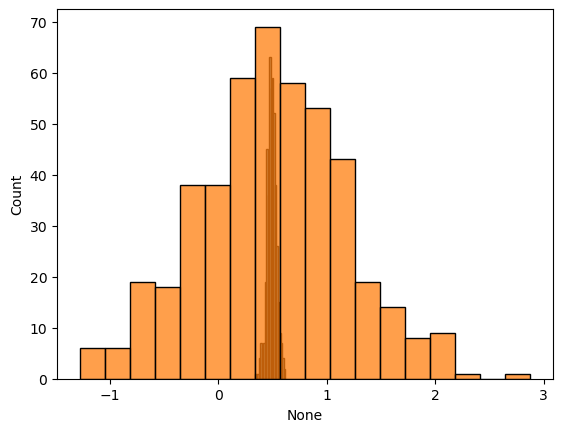

In [155]:
ax = sns.histplot(
    x=draws[y_tilde_cols].mean(axis="rows")
)

sns.histplot(
    x=df_test_i["log_cpy"],
    ax=ax,
)


### Posterior Predictive Check

In [ ]:
model_ppc = cmdstanpy.CmdStanModel(stan_file='../stan_models/linear_regression_ppc.stan')

In [ ]:
new_quantities = model_ppc.generate_quantities(data=data, previous_fit=fit)

In [ ]:
samples = new_quantities.draws_pd(inc_sample=True)

In [ ]:
y_rep_cols = [col for col in samples.columns if 'y_rep' in col]

In [ ]:
means = samples[y_rep_cols].mean(axis='rows')

In [ ]:
diffs = means - data["y"]

In [ ]:
ax = sns.histplot(
    samples[y_rep_cols].values.flatten(),
)
sns.histplot(
    data["y"],
    ax=ax
)

In [ ]:
sns.histplot(
    data=diffs
)